# Steps
---
1. Data feature gathering
2. Understading data Dristribution
3. Oversampeling data target
4. Train model to predict normal or abnormal
5. K-mean clusterin to classifiy the model find types of abnormal
6. Pickel files 


In [73]:
!pip freeze > requirements.txt

In [2]:
from urllib.request import urlopen
import urllib.request

from zipfile import ZipFile
from io import BytesIO
import os, zipfile

from pathlib import Path
from sys import argv

import librosa
import numpy as np
import pandas as pd

In [186]:
main_dir_db = os.listdir("./dataset")
main_dir_cata = os.listdir(f"./dataset/{main_dir_db[0]}")
main_dir_id = os.listdir(f"./dataset/{main_dir_db[0]}/{main_dir_cata[0]}")
main_dir_abn = os.listdir(f"./dataset/{main_dir_db[0]}/{main_dir_cata[0]}/{main_dir_id[0]}/abnormal")
main_dir_nor = os.listdir(f"./dataset/{main_dir_db[0]}/{main_dir_cata[0]}/{main_dir_id[0]}/normal")

In [187]:
main_dir_db

['-6_dB_fan']

In [188]:
main_dir_abn

['00000000.wav',
 '00000001.wav',
 '00000002.wav',
 '00000003.wav',
 '00000004.wav',
 '00000005.wav',
 '00000006.wav',
 '00000007.wav',
 '00000008.wav',
 '00000009.wav',
 '00000010.wav',
 '00000011.wav',
 '00000012.wav',
 '00000013.wav',
 '00000014.wav',
 '00000015.wav',
 '00000016.wav',
 '00000017.wav',
 '00000018.wav',
 '00000019.wav',
 '00000020.wav',
 '00000021.wav',
 '00000022.wav',
 '00000023.wav',
 '00000024.wav',
 '00000025.wav',
 '00000026.wav',
 '00000027.wav',
 '00000028.wav',
 '00000029.wav',
 '00000030.wav',
 '00000031.wav',
 '00000032.wav',
 '00000033.wav',
 '00000034.wav',
 '00000035.wav',
 '00000036.wav',
 '00000037.wav',
 '00000038.wav',
 '00000039.wav',
 '00000040.wav',
 '00000041.wav',
 '00000042.wav',
 '00000043.wav',
 '00000044.wav',
 '00000045.wav',
 '00000046.wav',
 '00000047.wav',
 '00000048.wav',
 '00000049.wav',
 '00000050.wav',
 '00000051.wav',
 '00000052.wav',
 '00000053.wav',
 '00000054.wav',
 '00000055.wav',
 '00000056.wav',
 '00000057.wav',
 '00000058.wav

In [13]:
# Beat tracking example
import librosa

# 1. Get the file path to an included audio example
# filename = librosa.example(f'./dataset/{main_dir_db[0]}/{main_dir_cata[0]}/{main_dir_id[0]}/normal/{main_dir_abn[0]}')


# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load(f'./dataset/{main_dir_db[0]}/{main_dir_cata[0]}/{main_dir_id[0]}/normal/{main_dir_abn[0]}')

# 3. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

Estimated tempo: 99.38 beats per minute


In [31]:
# Feature extraction example
import numpy as np
import librosa

# Load the example clip
y, sr = librosa.load(f'./dataset/{main_dir_db[0]}/{main_dir_cata[0]}/{main_dir_id[0]}/normal/{main_dir_abn[5]}')

# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
hop_length = 512

# Separate harmonics and percussives into two waveforms
y_harmonic, y_percussive = librosa.effects.hpss(y)

# Beat track on the percussive signal
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,
                                             sr=sr)

# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)

# And the first-order differences (delta features)
mfcc_delta = librosa.feature.delta(mfcc)

# Stack and synchronize between beat events
# This time, we'll use the mean value (default) instead of median
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]),
                                    beat_frames)

# Compute chroma features from the harmonic signal
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                        sr=sr)

# Aggregate chroma features between beat events
# We'll use the median value of each feature between beat frames
beat_chroma = librosa.util.sync(chromagram, beat_frames, aggregate=np.median)

# Finally, stack all beat-synchronous features together
beat_features_5 = np.vstack([beat_chroma, beat_mfcc_delta])

In [28]:
beat_features_0.shape

(38, 16)

In [30]:
beat_features_1.shape

(38, 25)

In [32]:
beat_features_5.shape

(38, 24)

In [ ]:
def get_audio_features(wavefile: str) -> dict:
    """Extract features from a provided audio file.
    :param wavefile: path to audio file
    """
    librosa.load(wavefile)

    return {}


def extract_dataset(filepath: str, sound_func=None) -> pd.DataFrame:
    """Extract data points from MIMII zip file. Every .wav file will become one
    data point. An function to extract data from the content of each file can
    be specified.
    :param filepath: Path to the zip file which holds all the wav files.
    :param sound_func: Function that extracts audio features from each wave file. 
    :return: Pandas DataFrame with all features 
    """
    # convert to Path object for easy path methods
    filepath = Path(filepath)
    setname = filepath.stem  # name of archive
    SNR = int(setname.split("_")[0])  # get dB from name -6_dB_slider → -6
    machine = setname.split("_")[2]

    data = {
        "dataset": filepath.name,
        "machine": machine,
        "SNR": SNR,
        "machine_id": [],
        "wavefile": [],
        "is_normal": [],
    }

    with zipfile.ZipFile(filepath, "r") as file:
        for soundfile in file.infolist():
            # loop through zip contents, only do .wav files
            if soundfile.filename.endswith(".wav"):
                # convert to Path for easy
                soundfilename = Path(soundfile.filename)
                # target feature: is normal or abnormal?
                is_normal = not soundfilename.parts[-2].endswith("abnormal")
                # machine id from folder name: id_01 → 1
                machine_id = int(soundfilename.parts[-3].split("_")[-1])

                # add row to data
                data["wavefile"].append(str(soundfilename))
                data["is_normal"].append(is_normal)
                data["machine_id"].append(machine_id)

    return pd.DataFrame(data)


if __name__ == "__main__":
    # Read zipfile from command line.
    if len(argv) > 1:
        extract_dataset(argv[1])

---
# Machine Learning
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

In [2]:
dataset = pd.read_csv('slider_0dB.csv.xz')
dataset.head()

,dataset,machine,SNR,machine_id,wavefile,is_normal,duration,rms_mean,rms_median,rms_std,mfcc_mean,mfcc_median,mfcc_std,mel_mean,mel_median,mel_std
0,0_dB_slider.zip,slider,0,0,slider/id_00/abnormal/00000000.wav,False,10.0,0.007822,0.007822,0.002175,-10.934783,-10.934783,94.153847,0.014668,0.014668,0.090881
1,0_dB_slider.zip,slider,0,0,slider/id_00/abnormal/00000001.wav,False,10.0,0.008041,0.008041,0.002220,-11.310746,-11.310746,93.869919,0.015486,0.015486,0.096406
2,0_dB_slider.zip,slider,0,0,slider/id_00/abnormal/00000002.wav,False,10.0,0.008052,0.008052,0.002170,-11.751987,-11.751987,94.153526,0.015526,0.015526,0.095412
3,0_dB_slider.zip,slider,0,0,slider/id_00/abnormal/00000003.wav,False,10.0,0.007545,0.007545,0.002314,-12.068364,-12.068364,91.861923,0.013673,0.013673,0.091515
4,0_dB_slider.zip,slider,0,0,slider/id_00/abnormal/00000004.wav,False,10.0,0.007863,0.007863,0.002166,-11.211153,-11.211153,93.394203,0.014752,0.014752,0.092520


In [3]:
dataset = dataset[["rms_mean", "rms_median", "rms_std", "mfcc_mean", "mfcc_median", "mfcc_std", "mel_mean", "mel_median", "mel_std", "is_normal"]]

dataset = pd.read_csv('Mall_Customers.csv')
dataset
X = dataset.iloc[:, [3,4]].values      # we don't have 'y' there is no dependent variable just feature to identify the clusters.    
# we are only using 2 feature just beacuse its easy to visualize in 2D diagram

In [4]:
dataset.head()

,rms_mean,rms_median,rms_std,mfcc_mean,mfcc_median,mfcc_std,mel_mean,mel_median,mel_std,is_normal
0,0.007822,0.007822,0.002175,-10.934783,-10.934783,94.153847,0.014668,0.014668,0.090881,False
1,0.008041,0.008041,0.002220,-11.310746,-11.310746,93.869919,0.015486,0.015486,0.096406,False
2,0.008052,0.008052,0.002170,-11.751987,-11.751987,94.153526,0.015526,0.015526,0.095412,False
3,0.007545,0.007545,0.002314,-12.068364,-12.068364,91.861923,0.013673,0.013673,0.091515,False
4,0.007863,0.007863,0.002166,-11.211153,-11.211153,93.394203,0.014752,0.014752,0.092520,False


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset.is_normal = le.fit_transform(dataset.is_normal)

In [6]:
dataset

,rms_mean,rms_median,rms_std,mfcc_mean,mfcc_median,mfcc_std,mel_mean,mel_median,mel_std,is_normal
0,0.007822,0.007822,0.002175,-10.934783,-10.934783,94.153847,0.014668,0.014668,0.090881,0
1,0.008041,0.008041,0.002220,-11.310746,-11.310746,93.869919,0.015486,0.015486,0.096406,0
2,0.008052,0.008052,0.002170,-11.751987,-11.751987,94.153526,0.015526,0.015526,0.095412,0
3,0.007545,0.007545,0.002314,-12.068364,-12.068364,91.861923,0.013673,0.013673,0.091515,0
4,0.007863,0.007863,0.002166,-11.211153,-11.211153,93.394203,0.014752,0.014752,0.092520,0
...,...,...,...,...,...,...,...,...,...,...
4089,0.005241,0.005241,0.001560,-12.789686,-12.789686,102.643967,0.006680,0.006680,0.036023,1
4090,0.005587,0.005587,0.001407,-11.614548,-11.614548,106.074684,0.007514,0.007514,0.033954,1
4091,0.004855,0.004855,0.001675,-13.727771,-13.727771,95.083153,0.005381,0.005381,0.031847,1
4092,0.005220,0.005220,0.001639,-12.932367,-12.932367,101.329132,0.006604,0.006604,0.034681,1


,Column Name,Missing Count,Missing data %
0,rms_mean,0,0.0
1,rms_median,0,0.0
2,rms_std,0,0.0
3,mfcc_mean,0,0.0
4,mfcc_median,0,0.0
5,mfcc_std,0,0.0
6,mel_mean,0,0.0
7,mel_median,0,0.0
8,mel_std,0,0.0
9,is_normal,0,0.0


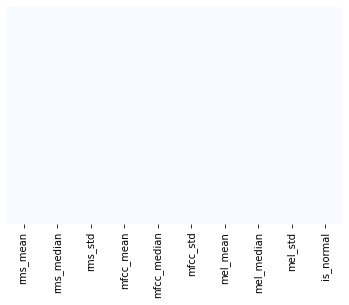

In [7]:
sn.heatmap(dataset.isnull(), yticklabels= False, cbar= False, cmap= 'Blues');

missing_df = dataset.isnull().sum(axis=0).reset_index()
missing_df.columns = ['Column Name', 'Missing Count']

# % of data present out of total
missing_df['Missing data %'] = round(missing_df['Missing Count'] / dataset.shape[0] * 100, 2)
missing_df = missing_df.sort_values('Missing data %',ascending=False).reset_index(drop = True)
missing_df

<ipython-input-8-fe71cd180db7>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(plt_row, plt_col, i + 1)


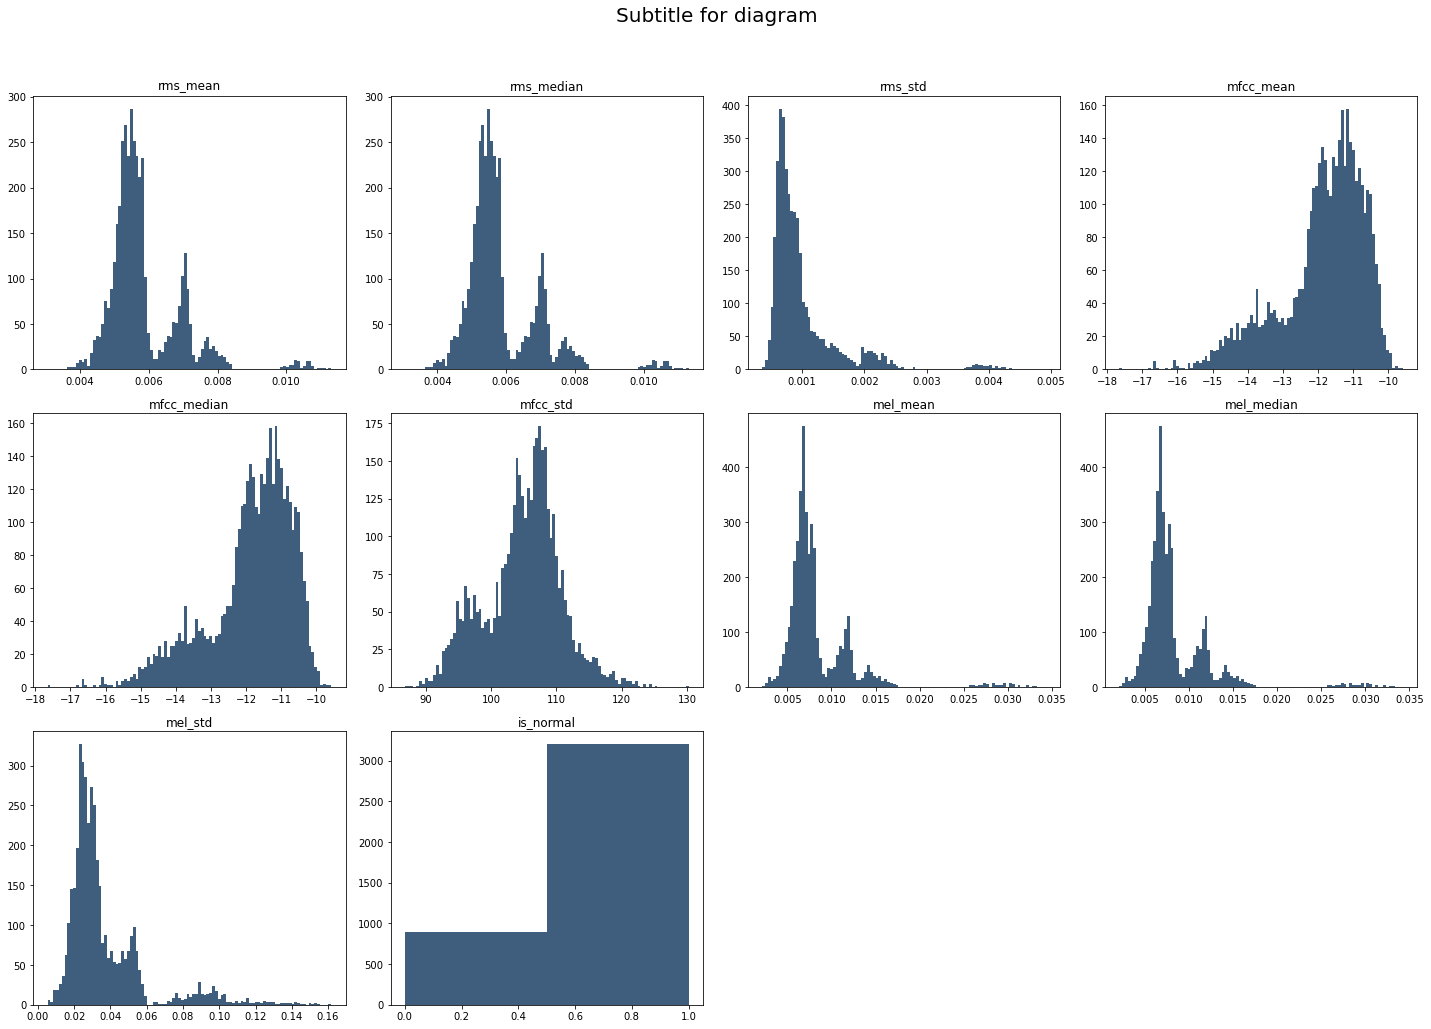

In [8]:
dataset2 = dataset
column_headers = dataset2.columns
feature_col = dataset2.shape[1]
plt_col = 4
plt_row = (len(column_headers)/plt_col) + 1


fig = plt.figure(figsize=(20, 15))
plt.suptitle('Subtitle for diagram', fontsize=20)
for i in range(feature_col):
    plt.subplot(plt_row, plt_col, i + 1)
    f = plt.gca()
    f.set_title(dataset2.columns.values[i])

    vals = np.size(dataset2.iloc[:, i].unique())
    
    # This help ploting process easier
    if vals >= 100:
        vals = 100
    
    plt.hist(dataset2.iloc[:, i], bins=vals, color='#3F5D7D')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

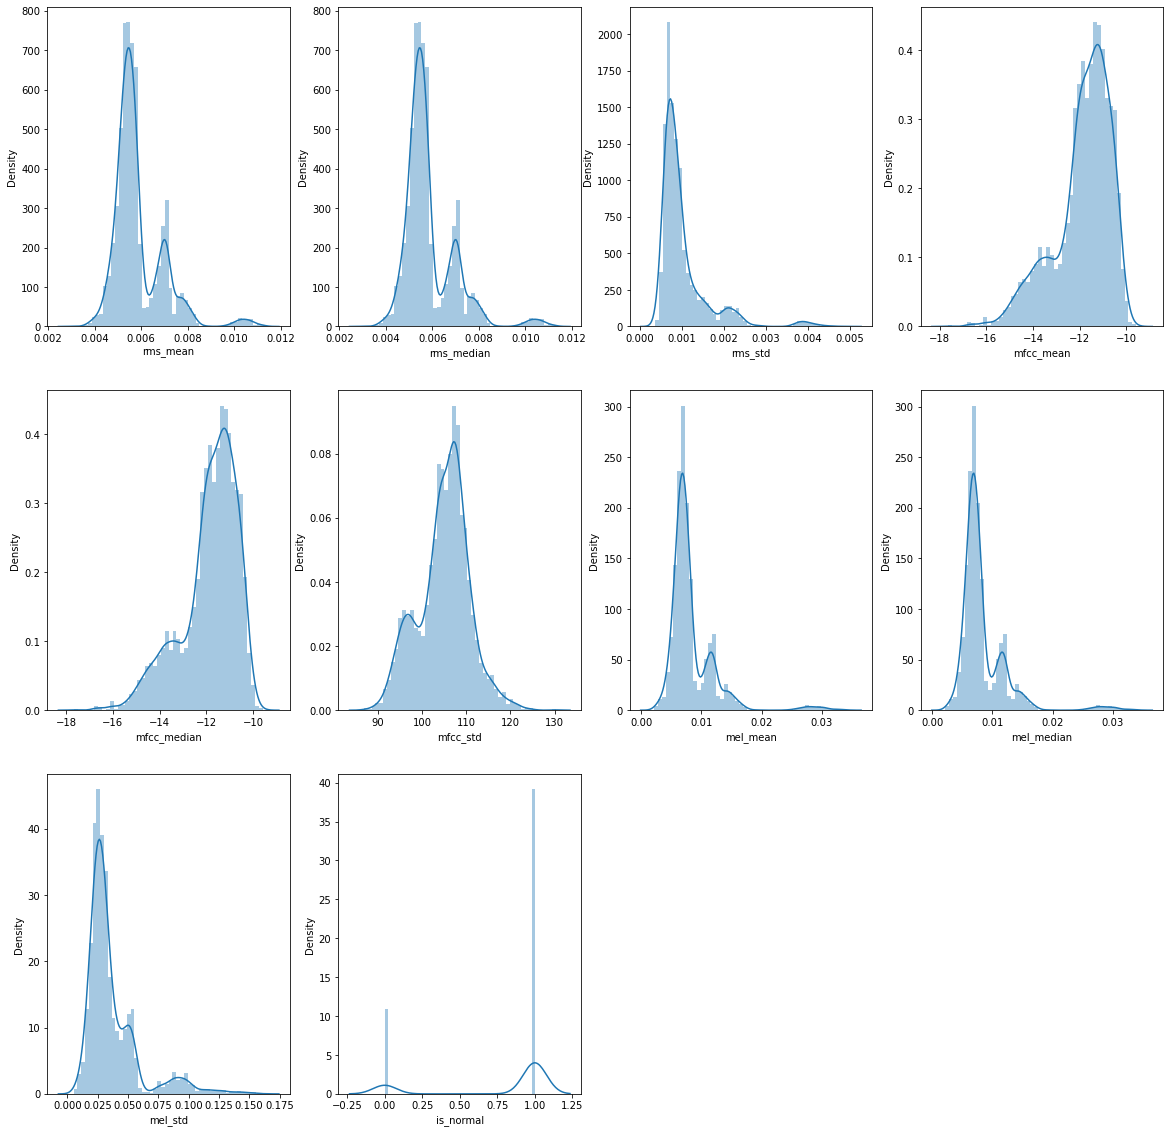

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

column_headers = dataset2.columns
plt_col = 4
plt_row = int(len(column_headers)/plt_col) + 1 

i = 1
fig, ax = plt.subplots(2, plt_col, figsize = (20, 20))

for column_header in column_headers:
    plt.subplot(plt_row,plt_col,i)
    sn.distplot(dataset[column_header])
    i = i + 1

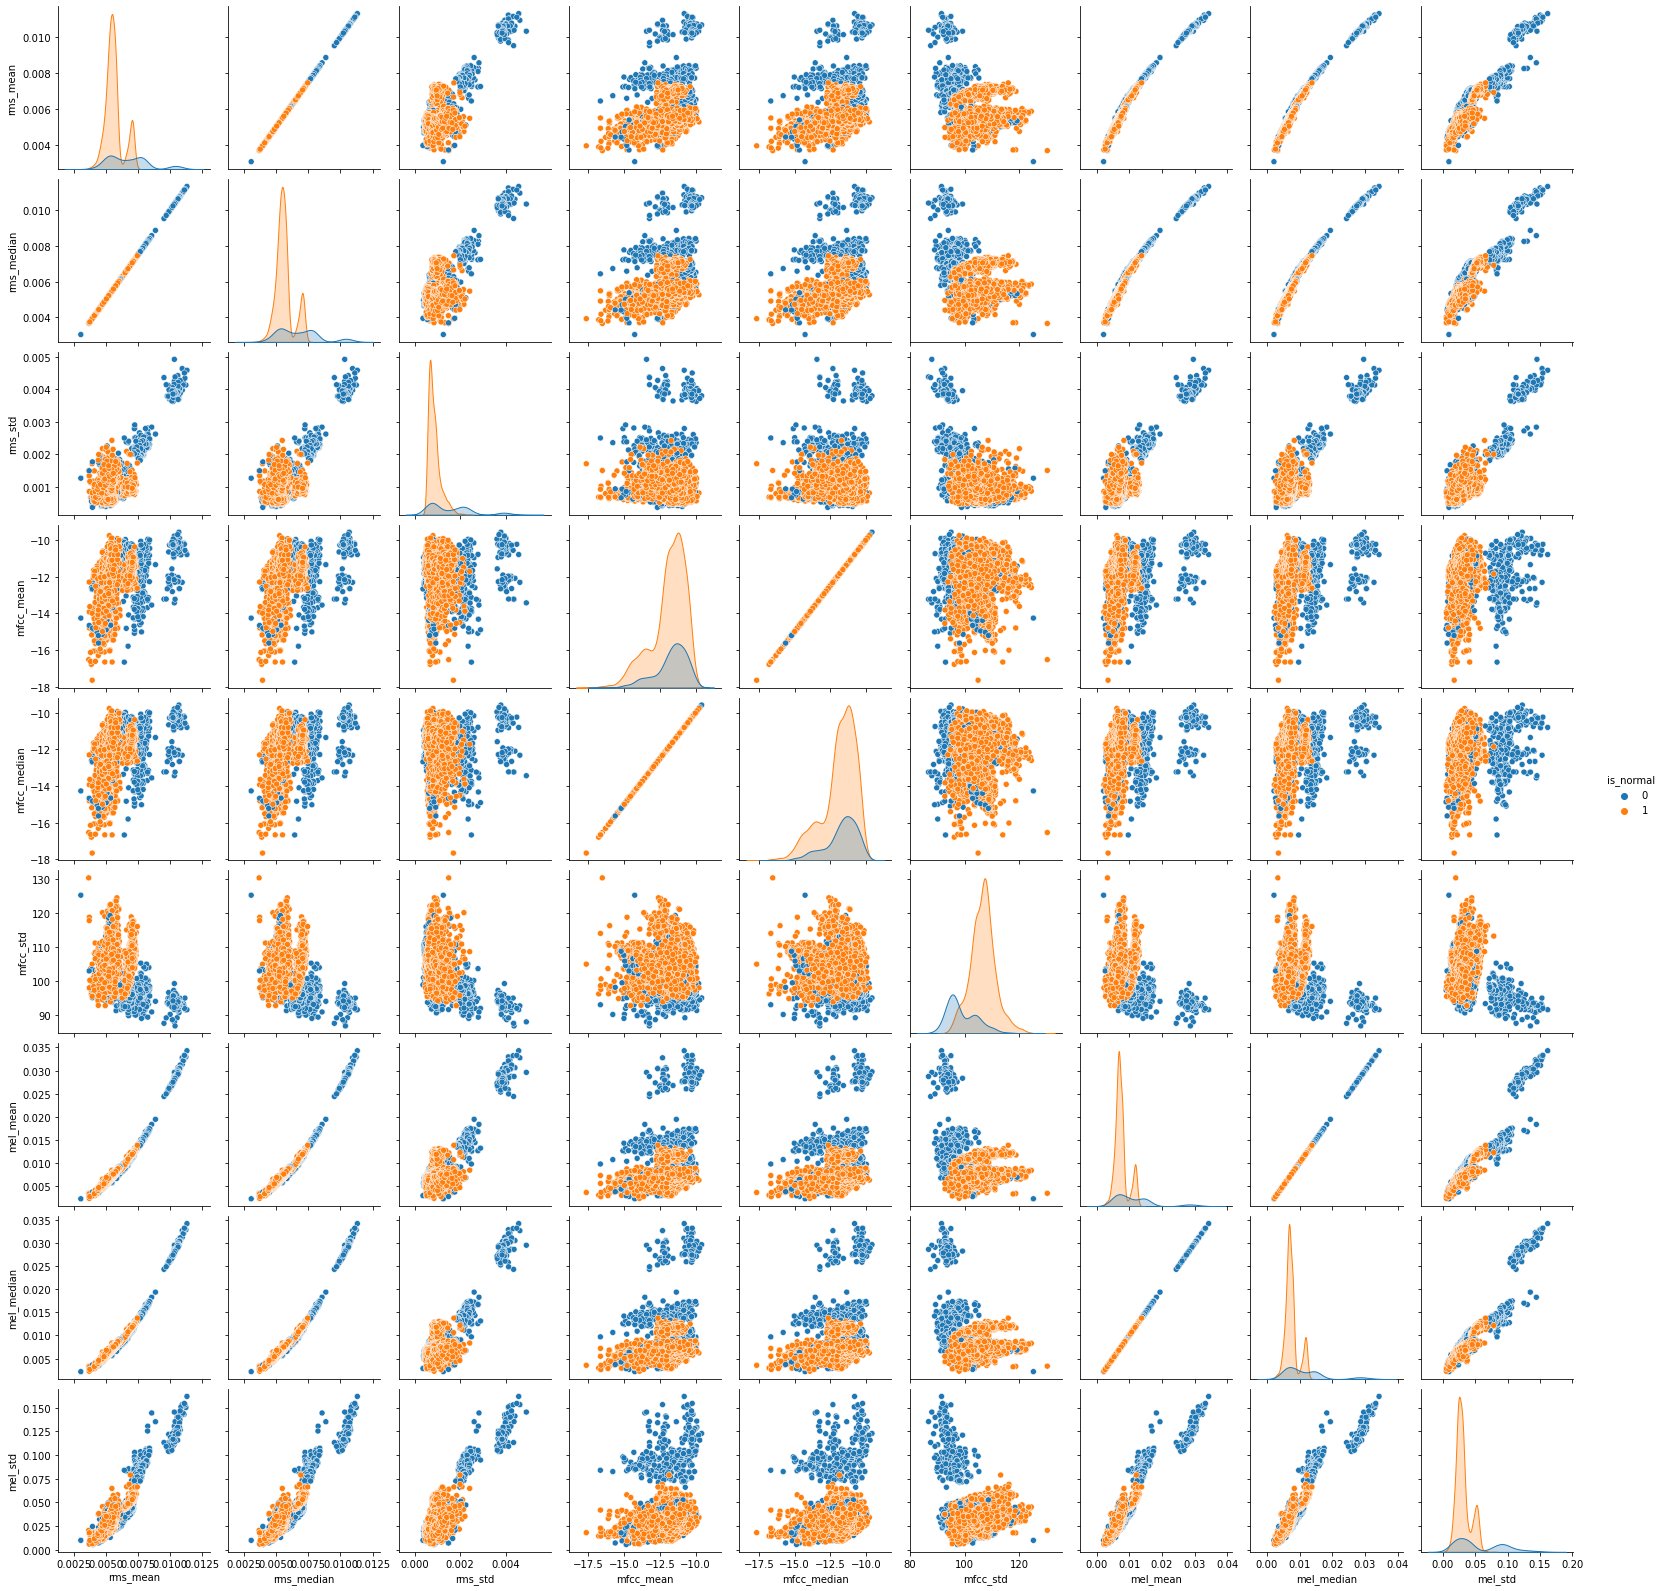

In [10]:
sn.pairplot(dataset, hue="is_normal");

In [49]:
dataset.columns

Index(['rms_mean', 'rms_median', 'rms_std', 'mfcc_mean', 'mfcc_median',
       'mfcc_std', 'mel_mean', 'mel_median', 'mel_std', 'is_normal'],
      dtype='object')

<ipython-input-12-341f41c7a2b9>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


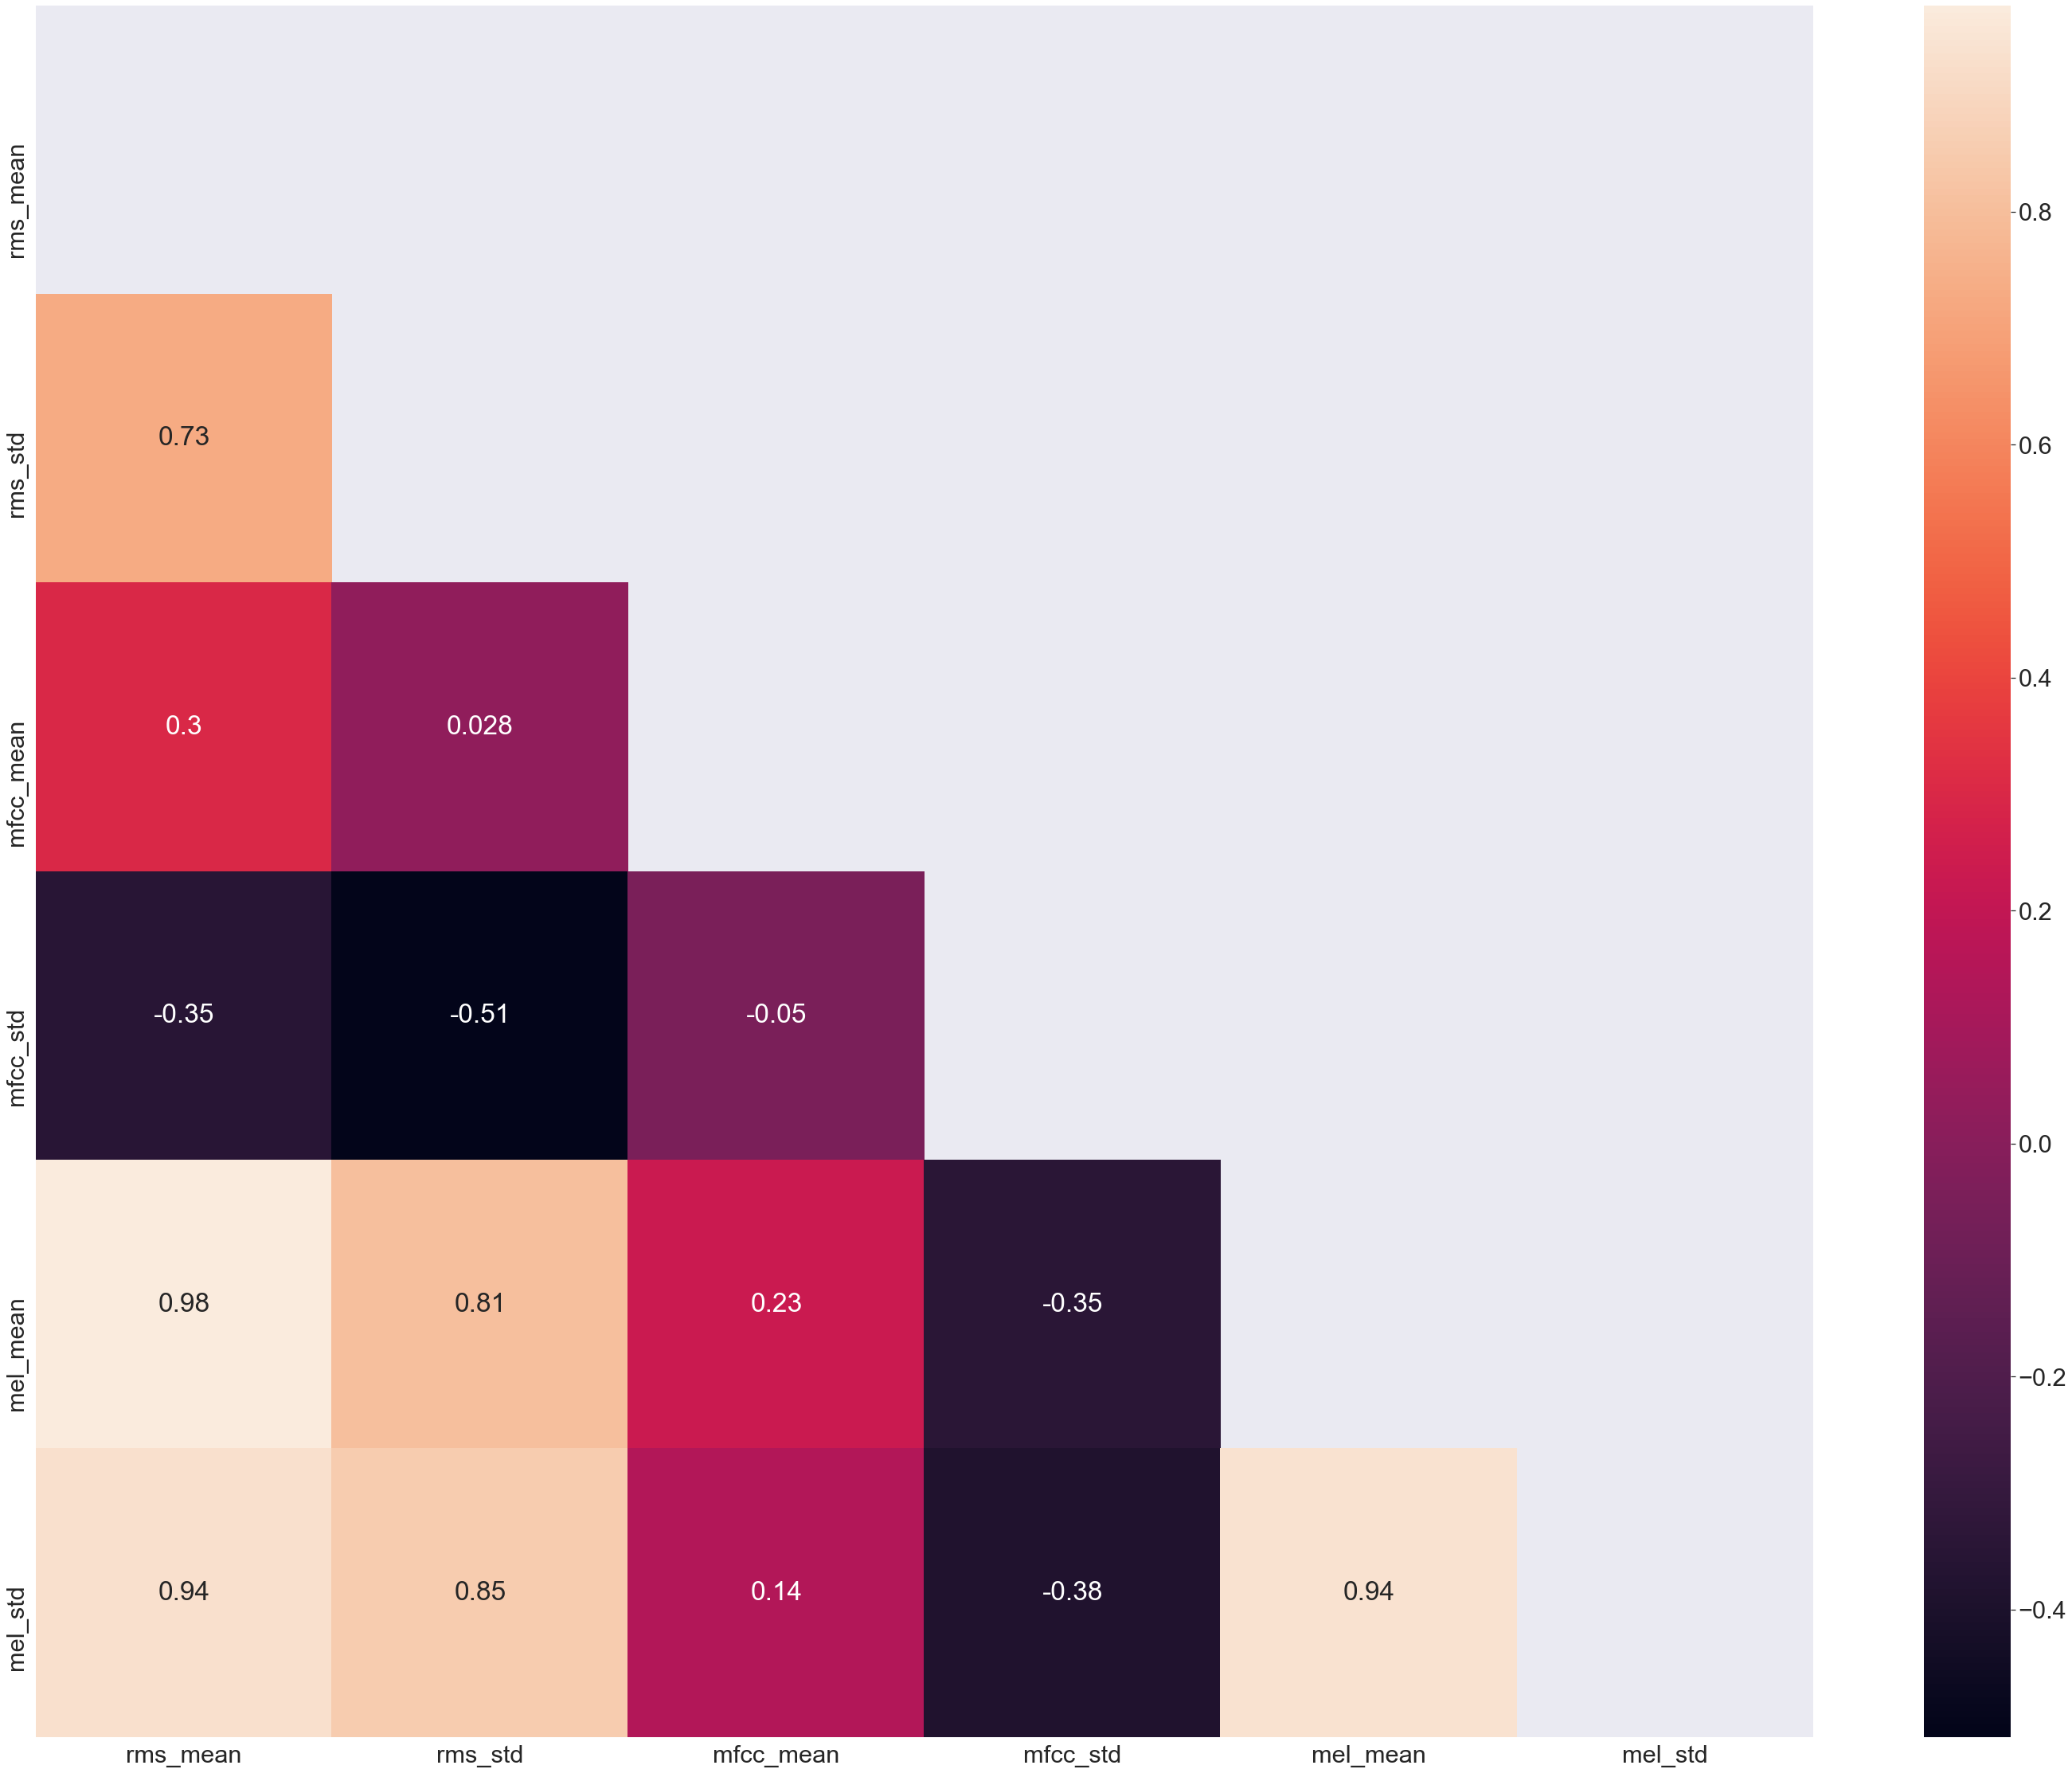

In [12]:
## Correlation every feature
dataset2 = dataset[['rms_mean', 'rms_std', 
                    'mfcc_mean','mfcc_std', 
                    'mel_mean', 'mel_std',]]
corr = dataset2.corr()
sn.set(font_scale=2.8)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (50,40))
sn.heatmap(corr, annot=True,mask=mask);

# Filter high correalted columns

In [51]:
dataset2.columns

Index(['mel_std', 'mfcc_mean', 'mfcc_std'], dtype='object')

## Balancing dataset (Generalize)

In [52]:
dataset = pd.read_csv('slider_0dB.csv.xz')
# dataset = dataset[["rms_mean", "rms_median", "rms_std", 
#                    "mfcc_mean", "mfcc_median", "mfcc_std", 
#                    "mel_mean", "mel_median", "mel_std", 
#                    "is_normal"]]

dataset = dataset[['rms_mean', 'rms_std', 
                    'mfcc_mean','mfcc_std', 
                    'mel_mean', 'mel_std',
                  "is_normal"]]
X = dataset.drop("is_normal", axis=1)
y = dataset["is_normal"]

# catagory to binary
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [74]:
from imblearn.over_sampling import SMOTE

X_resample, y_resample = SMOTE().fit_resample(X,y.ravel())

y_resample = pd.DataFrame(y_resample)
X_resample = pd.DataFrame(X_resample)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resample,y_resample,test_size=0.3)

ModuleNotFoundError: No module named 'imblearn'

In [54]:
print(y_resample.value_counts())
print()
sn.distplot(y_resample);

NameError: name 'y_resample' is not defined

## Machine Learning Classification 

In [13]:

# id_no = dataset['seprate identifing number if present']
# X = dataset.drop(columns = ["identifing number", "independent variable"])
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
"""
"""

'\n'

## Function to check perfomance

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

def perfomance_check(name: str):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label='positive',
                                           average='micro')
    rec = recall_score(y_test, y_pred, pos_label='positive',
                                           average='micro')
    f1 = f1_score(y_test, y_pred, pos_label='positive',
                                           average='micro')

    model_results = pd.DataFrame([[name, acc, prec, rec, f1]],
                   columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    return results.append(model_results, ignore_index = True)

results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Logical Regression (Default)

In [15]:
from sklearn.linear_model import LogisticRegression
LR_classifier = LogisticRegression(random_state = 0)
LR_classifier.fit(X_train, y_train.values.ravel())

y_pred = LR_classifier.predict(X_test)

results = perfomance_check('Linear Regression (Default)')

C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that

## Logical Regression

In [16]:
from sklearn.linear_model import LogisticRegression
LR_classifier = LogisticRegression(random_state = 0, penalty = 'l1', solver='saga')
LR_classifier.fit(X_train, y_train.values.ravel())

y_pred = LR_classifier.predict(X_test)

results = perfomance_check('Linear Regression (Lasso)')

C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packa

## KNN (K-Nearest Neighbours)

In [17]:
from sklearn.neighbors import KNeighborsClassifier
no_neighbor = 5
for i in range(1,no_neighbor+1):
    KNN_classifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
    KNN_classifier.fit(X_train, y_train.values.ravel())

    y_pred = KNN_classifier.predict(X_test)

    results = perfomance_check(f'K-Nearest Neighbours {i}')

C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that

## SVM

In [18]:
from sklearn.svm import SVC
SVML_classifier = SVC(random_state = 0, kernel = 'linear')
SVML_classifier.fit(X_train, y_train.values.ravel())

y_pred = SVML_classifier.predict(X_test)

results = perfomance_check('SVM (Linear)')

C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that

## Kernal SVM

In [19]:
from sklearn.svm import SVC
K_SVM_classifier = SVC(random_state = 0, kernel = 'rbf')
K_SVM_classifier.fit(X_train, y_train.values.ravel())

y_pred = K_SVM_classifier.predict(X_test)

results = perfomance_check('SVM (RBF)')

C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that

## Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB
NB_classifier = GaussianNB()
NB_classifier.fit(X_train, y_train.values.ravel())

y_pred = NB_classifier.predict(X_test)

results = perfomance_check('Naive Bayes')

C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that

## Decision Tree Classification

In [21]:
from sklearn.tree import DecisionTreeClassifier
DTC_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
DTC_classifier.fit(X_train, y_train.values.ravel())

y_pred = DTC_classifier.predict(X_test)

results = perfomance_check('Decision Tree Classification')

C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that

## Random Forest Classification

In [22]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier = RandomForestClassifier(random_state = 0, n_estimators = 100,
                                    criterion = 'entropy')
RF_classifier.fit(X_train, y_train.values.ravel())

y_pred = RF_classifier.predict(X_test)

results = perfomance_check('Random Forest (n=100)')

C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that

## XGBoost Classifier

In [23]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train.values.ravel())

y_pred = xgb_classifier.predict(X_test)

results = perfomance_check('XGBoost ')

C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that

## CatBoost Classifier

In [24]:
from catboost import CatBoostClassifier
CB_classifier = CatBoostClassifier()
CB_classifier.fit(X_train, y_train.values.ravel())

y_pred = CB_classifier.predict(X_test)

results = perfomance_check('CatBoost')

Learning rate set to 0.016148
0:	learn: 0.6717396	total: 169ms	remaining: 2m 48s
1:	learn: 0.6557128	total: 175ms	remaining: 1m 27s
2:	learn: 0.6382845	total: 182ms	remaining: 1m
3:	learn: 0.6230339	total: 192ms	remaining: 47.9s
4:	learn: 0.6083672	total: 199ms	remaining: 39.7s
5:	learn: 0.5941631	total: 206ms	remaining: 34.2s
6:	learn: 0.5800255	total: 213ms	remaining: 30.2s
7:	learn: 0.5658324	total: 219ms	remaining: 27.1s
8:	learn: 0.5539636	total: 224ms	remaining: 24.6s
9:	learn: 0.5420967	total: 229ms	remaining: 22.7s
10:	learn: 0.5320755	total: 237ms	remaining: 21.3s
11:	learn: 0.5215028	total: 241ms	remaining: 19.8s
12:	learn: 0.5097197	total: 249ms	remaining: 18.9s
13:	learn: 0.4980252	total: 255ms	remaining: 18s
14:	learn: 0.4876204	total: 259ms	remaining: 17s
15:	learn: 0.4788831	total: 265ms	remaining: 16.3s
16:	learn: 0.4704944	total: 269ms	remaining: 15.6s
17:	learn: 0.4633682	total: 275ms	remaining: 15s
18:	learn: 0.4540896	total: 280ms	remaining: 14.4s
19:	learn: 0.44651

171:	learn: 0.1928720	total: 1.22s	remaining: 5.85s
172:	learn: 0.1924106	total: 1.22s	remaining: 5.84s
173:	learn: 0.1920531	total: 1.23s	remaining: 5.83s
174:	learn: 0.1917736	total: 1.23s	remaining: 5.82s
175:	learn: 0.1915181	total: 1.24s	remaining: 5.81s
176:	learn: 0.1910896	total: 1.25s	remaining: 5.8s
177:	learn: 0.1906225	total: 1.25s	remaining: 5.78s
178:	learn: 0.1904053	total: 1.26s	remaining: 5.76s
179:	learn: 0.1901332	total: 1.26s	remaining: 5.76s
180:	learn: 0.1897005	total: 1.27s	remaining: 5.74s
181:	learn: 0.1892611	total: 1.27s	remaining: 5.72s
182:	learn: 0.1886285	total: 1.28s	remaining: 5.71s
183:	learn: 0.1882247	total: 1.28s	remaining: 5.7s
184:	learn: 0.1880049	total: 1.29s	remaining: 5.68s
185:	learn: 0.1875072	total: 1.29s	remaining: 5.67s
186:	learn: 0.1871814	total: 1.3s	remaining: 5.66s
187:	learn: 0.1866227	total: 1.3s	remaining: 5.64s
188:	learn: 0.1863584	total: 1.31s	remaining: 5.62s
189:	learn: 0.1859392	total: 1.31s	remaining: 5.61s
190:	learn: 0.18

347:	learn: 0.1478066	total: 2.26s	remaining: 4.23s
348:	learn: 0.1475865	total: 2.26s	remaining: 4.22s
349:	learn: 0.1472073	total: 2.27s	remaining: 4.22s
350:	learn: 0.1470281	total: 2.28s	remaining: 4.21s
351:	learn: 0.1468557	total: 2.28s	remaining: 4.21s
352:	learn: 0.1467307	total: 2.29s	remaining: 4.2s
353:	learn: 0.1464468	total: 2.29s	remaining: 4.19s
354:	learn: 0.1462349	total: 2.3s	remaining: 4.19s
355:	learn: 0.1460643	total: 2.31s	remaining: 4.18s
356:	learn: 0.1458944	total: 2.31s	remaining: 4.17s
357:	learn: 0.1456793	total: 2.32s	remaining: 4.16s
358:	learn: 0.1453504	total: 2.33s	remaining: 4.15s
359:	learn: 0.1452172	total: 2.33s	remaining: 4.15s
360:	learn: 0.1450272	total: 2.34s	remaining: 4.14s
361:	learn: 0.1447507	total: 2.34s	remaining: 4.13s
362:	learn: 0.1446329	total: 2.35s	remaining: 4.12s
363:	learn: 0.1444630	total: 2.35s	remaining: 4.11s
364:	learn: 0.1443143	total: 2.36s	remaining: 4.11s
365:	learn: 0.1442149	total: 2.37s	remaining: 4.1s
366:	learn: 0.1

509:	learn: 0.1214303	total: 3.28s	remaining: 3.15s
510:	learn: 0.1212857	total: 3.29s	remaining: 3.15s
511:	learn: 0.1211592	total: 3.29s	remaining: 3.14s
512:	learn: 0.1210127	total: 3.3s	remaining: 3.13s
513:	learn: 0.1208414	total: 3.31s	remaining: 3.13s
514:	learn: 0.1207070	total: 3.31s	remaining: 3.12s
515:	learn: 0.1206280	total: 3.32s	remaining: 3.11s
516:	learn: 0.1205530	total: 3.33s	remaining: 3.12s
517:	learn: 0.1204523	total: 3.34s	remaining: 3.11s
518:	learn: 0.1203407	total: 3.35s	remaining: 3.1s
519:	learn: 0.1201700	total: 3.35s	remaining: 3.1s
520:	learn: 0.1200435	total: 3.36s	remaining: 3.09s
521:	learn: 0.1199639	total: 3.37s	remaining: 3.08s
522:	learn: 0.1198612	total: 3.37s	remaining: 3.08s
523:	learn: 0.1197153	total: 3.38s	remaining: 3.07s
524:	learn: 0.1195933	total: 3.38s	remaining: 3.06s
525:	learn: 0.1193086	total: 3.39s	remaining: 3.05s
526:	learn: 0.1191237	total: 3.39s	remaining: 3.04s
527:	learn: 0.1188708	total: 3.4s	remaining: 3.04s
528:	learn: 0.11

687:	learn: 0.0989869	total: 4.33s	remaining: 1.96s
688:	learn: 0.0988285	total: 4.34s	remaining: 1.96s
689:	learn: 0.0986960	total: 4.34s	remaining: 1.95s
690:	learn: 0.0985723	total: 4.35s	remaining: 1.95s
691:	learn: 0.0984437	total: 4.36s	remaining: 1.94s
692:	learn: 0.0983110	total: 4.36s	remaining: 1.93s
693:	learn: 0.0981500	total: 4.37s	remaining: 1.93s
694:	learn: 0.0980322	total: 4.38s	remaining: 1.92s
695:	learn: 0.0978484	total: 4.38s	remaining: 1.92s
696:	learn: 0.0977253	total: 4.39s	remaining: 1.91s
697:	learn: 0.0976617	total: 4.4s	remaining: 1.9s
698:	learn: 0.0975462	total: 4.4s	remaining: 1.9s
699:	learn: 0.0974632	total: 4.41s	remaining: 1.89s
700:	learn: 0.0972920	total: 4.42s	remaining: 1.89s
701:	learn: 0.0971712	total: 4.43s	remaining: 1.88s
702:	learn: 0.0971022	total: 4.44s	remaining: 1.87s
703:	learn: 0.0970187	total: 4.44s	remaining: 1.87s
704:	learn: 0.0969611	total: 4.45s	remaining: 1.86s
705:	learn: 0.0968516	total: 4.46s	remaining: 1.85s
706:	learn: 0.09

848:	learn: 0.0836644	total: 5.36s	remaining: 953ms
849:	learn: 0.0835899	total: 5.37s	remaining: 947ms
850:	learn: 0.0835118	total: 5.37s	remaining: 940ms
851:	learn: 0.0834708	total: 5.38s	remaining: 934ms
852:	learn: 0.0834138	total: 5.38s	remaining: 928ms
853:	learn: 0.0833040	total: 5.39s	remaining: 921ms
854:	learn: 0.0832193	total: 5.39s	remaining: 915ms
855:	learn: 0.0831443	total: 5.4s	remaining: 909ms
856:	learn: 0.0830738	total: 5.41s	remaining: 902ms
857:	learn: 0.0830067	total: 5.41s	remaining: 895ms
858:	learn: 0.0829522	total: 5.42s	remaining: 889ms
859:	learn: 0.0828687	total: 5.42s	remaining: 883ms
860:	learn: 0.0827410	total: 5.43s	remaining: 877ms
861:	learn: 0.0826410	total: 5.43s	remaining: 870ms
862:	learn: 0.0825507	total: 5.44s	remaining: 864ms
863:	learn: 0.0824746	total: 5.45s	remaining: 858ms
864:	learn: 0.0823717	total: 5.46s	remaining: 851ms
865:	learn: 0.0823114	total: 5.46s	remaining: 846ms
866:	learn: 0.0822718	total: 5.47s	remaining: 839ms
867:	learn: 0

C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\sijal\anaconda3\envs\ML_audio_prediction\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that

In [25]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Linear Regression (Lasso),0.882018,0.882018,0.882018,0.882018
1,Linear Regression (Lasso),0.779496,0.779496,0.779496,0.779496
2,K-Nearest Neighbours 1,0.819365,0.819365,0.819365,0.819365
3,K-Nearest Neighbours 2,0.772986,0.772986,0.772986,0.772986
4,K-Nearest Neighbours 3,0.857608,0.857608,0.857608,0.857608
5,K-Nearest Neighbours 4,0.834825,0.834825,0.834825,0.834825
6,K-Nearest Neighbours 5,0.862490,0.862490,0.862490,0.862490
7,SVM (Linear),0.891782,0.891782,0.891782,0.891782
8,SVM (RBF),0.877950,0.877950,0.877950,0.877950
9,Naive Bayes,0.791701,0.791701,0.791701,0.791701


---
# MODEL SELECTION
---

### K-fold Cross Validation
---
* Conside which model perform the best

In [26]:
model_lst = [LR_classifier,    # 0
             KNN_classifier,   # 1
             SVML_classifier,  # 2
             K_SVM_classifier, # 3
             NB_classifier,    # 4
             DTC_classifier,   # 5
             RF_classifier,    # 6
             xgb_classifier,   # 7
             CB_classifier]    # 8
msg = []
for i in range(len(model_lst)):
    accuracies = cross_val_score(estimator =model_lst[i] , X = X_train, y = y_train, cv = 10)
    msg.append(f"Model Accuracy {i}: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))
    
for i in msg:
    print(i)    

NameError: name 'cross_val_score' is not defined

In [163]:
for i in msg:
    print(i)

Model Accuracy 0: 0.879 (+/- 0.203)
Model Accuracy 1: 0.986 (+/- 0.057)
Model Accuracy 2: 0.979 (+/- 0.091)
Model Accuracy 3: 0.986 (+/- 0.057)
Model Accuracy 4: 0.979 (+/- 0.065)
Model Accuracy 5: 0.979 (+/- 0.065)
Model Accuracy 6: 0.986 (+/- 0.057)
Model Accuracy 7: 0.971 (+/- 0.070)
Model Accuracy 8: 0.993 (+/- 0.043)


In [77]:
# This is the script to compare result with prediction
comparision = pd.DataFrame(columns = ['Result', 'Prediction'])
try:
    comparision.Prediction = t_pred.tolist() #pd.Series(y_pred)
except:
    comparision.Prediction = pd.Series(y_pred.reshape(len(y_pred),))
comparision.Result = pd.Series(y_test.values.reshape(len(y_test),))

In [78]:
comparision

,Result,Prediction
0,1,0
1,1,1
2,1,0
3,0,1
4,0,0
...,...,...
1918,0,0
1919,0,0
1920,1,1
1921,0,0


In [79]:
comparision[comparision.Result != comparision.Prediction]

,Result,Prediction
0,1,0
2,1,0
3,0,1
5,0,1
6,0,1
...,...,...
1891,1,0
1892,1,0
1894,0,1
1898,0,1


## K-mean clustering
* Sub catogorize abnormal dataset.

## Using the elbow method to find the optimal number of clusters

In [28]:
cluster_dataset = pd.read_csv('slider_0dB.csv.xz')
cluster_dataset = cluster_dataset[['mel_std',  'mfcc_mean', 'mfcc_std']]

normal_dataset = cluster_dataset[dataset.is_normal == 1].iloc[:,:3]
abnormal_dataset = cluster_dataset[dataset.is_normal == 0].iloc[:,:3]

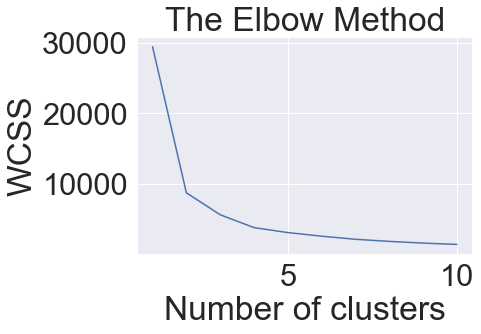

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(abnormal_dataset)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Training the K-Means model on the dataset

In [30]:
no_cluster = 4
kmeans = KMeans(n_clusters = no_cluster, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(abnormal_dataset)

In [31]:
abnormal_dataset["Target"] = y_kmeans.tolist()

In [32]:
abnormal_dataset

,mel_std,mfcc_mean,mfcc_std,Target
0,0.090881,-10.934783,94.153847,3
1,0.096406,-11.310746,93.869919,3
2,0.095412,-11.751987,94.153526,3
3,0.091515,-12.068364,91.861923,3
4,0.092520,-11.211153,93.394203,3
...,...,...,...,...
3555,0.036544,-11.179104,94.697350,3
3556,0.041067,-11.574075,101.727554,2
3557,0.033679,-13.648520,96.646973,1
3558,0.041284,-10.951503,103.248466,2


In [33]:
print(abnormal_dataset[abnormal_dataset.Target == 0].shape)
print(abnormal_dataset[abnormal_dataset.Target == 1].shape)
print(abnormal_dataset[abnormal_dataset.Target == 2].shape)
print(abnormal_dataset[abnormal_dataset.Target == 3].shape)

(85, 4)
(290, 4)
(237, 4)
(278, 4)


## Visualising the clusters

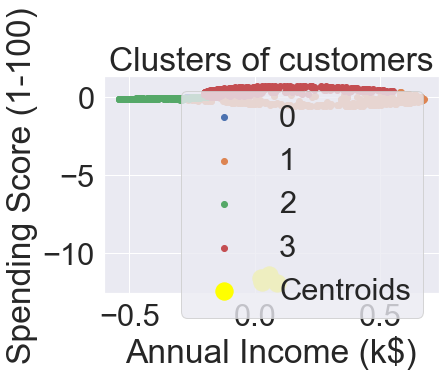

In [34]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 2, kernel = 'rbf')   # we can use kerenal to improve the perfomance
test_dataset = kpca.fit_transform(abnormal_dataset.iloc[:,:-1])


for i in range(no_cluster):
    plt.scatter(test_dataset[y_kmeans == i , 0] , test_dataset[y_kmeans == i , 1] , label = i)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend();